In [1]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling

import torch
from utils import one_hot
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/Users/scrotti/Aptamer2025py/selex_dca.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
experiment_id = "Dop8V030"
round_ids = ["ARN", "R01"]

device = torch.device("cpu")
dtype = torch.float32

In [3]:
sequences = [utils.sequences_from_file(experiment_id, round_id, device) for round_id in round_ids]

In [4]:
sequences_oh = [one_hot(seq).to(dtype=dtype, device=device) for seq in sequences]
freq_single_tuple, freq_pair_tuple, total_reads_tuple = zip(
    *[utils.frequences_from_sequences_oh(seq, pseudo_count=0.0) for seq in sequences_oh])
fi = torch.stack(freq_single_tuple).to(device=device, dtype=dtype)  # n_rounds, L, q
fij = torch.stack(freq_pair_tuple).to(device=device, dtype=dtype)     # n_rounds, L, q, L, q
total_reads = torch.tensor(total_reads_tuple).to(device=device, dtype=dtype)
n_rounds, L, q = fi.size()

In [178]:
import importlib
importlib.reload(indep_sites)
importlib.reload(selex_distribution)
importlib.reload(energy_models)
importlib.reload(training)

<module 'training' from '/Users/scrotti/Aptamer2025py/training.py'>

In [179]:
k = torch.log(fi[0])
h = torch.log(fi[-1]) - torch.log(fi[0])
k = torch.zeros(L, q, dtype=dtype, device=device)
h = torch.zeros(L, q, dtype=dtype, device=device)

tr = tree.Tree()
tr.add_node(-1)

selected_modes = torch.BoolTensor([[1]]).to(device)

Ns0 = energy_models.IndepSites(k)
indep = energy_models.IndepSites(h)
ps = selex_distribution.MultiModeDistribution(indep, normalized=False)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes)

In [180]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [181]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, device, dtype)
log_weights = torch.zeros(n_rounds, n_chains, device=device, dtype=dtype)

In [182]:
callbacks = [callback.ConvergenceMetricsCallback()]

In [183]:
n_sweeps = 10
lr = 0.01
target_pearson = 1
max_epochs = 200

training.train(model, data_loaders, total_reads, chains, n_sweeps, lr, max_epochs, target_pearson,
               callbacks=callbacks, log_weights=log_weights)

 0.00%[                              ] Epoch: 0/200 [00:00, ?it/s]

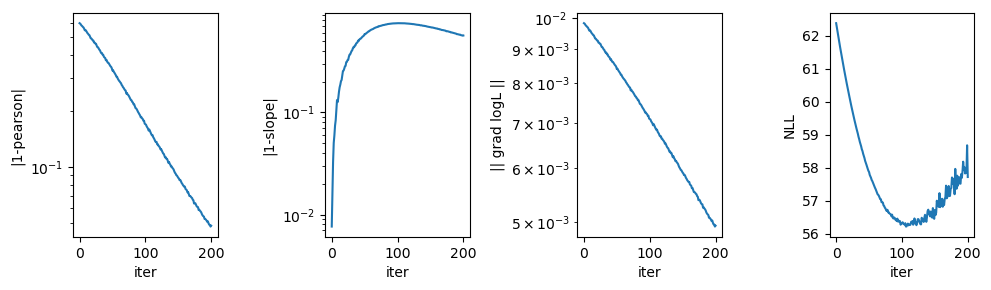

In [184]:
callbacks[0].plot();

In [141]:
params = indep_sites.init_parameters(fi)
params["bias_Ns0"] = torch.zeros(L, q, dtype=dtype, device=device)
params["bias_ps"] = torch.zeros(L, q, dtype=dtype, device=device)
params, history = indep_sites.train(
    fi=fi,
    total_reads=total_reads, 
    params=params,
    lr=lr,
    max_epochs=10**3,
    target_error=0,
    progress_bar=False)

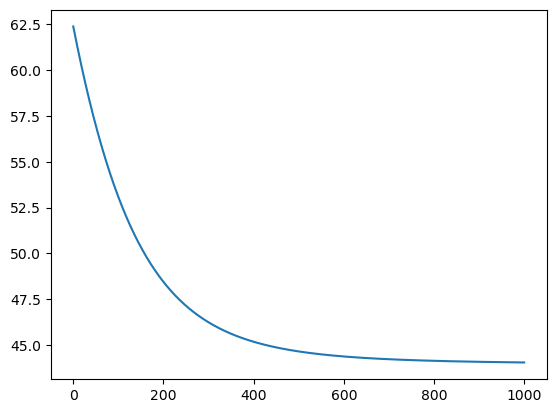

In [142]:
plt.plot([-l for l in history["log-likelihood"]])

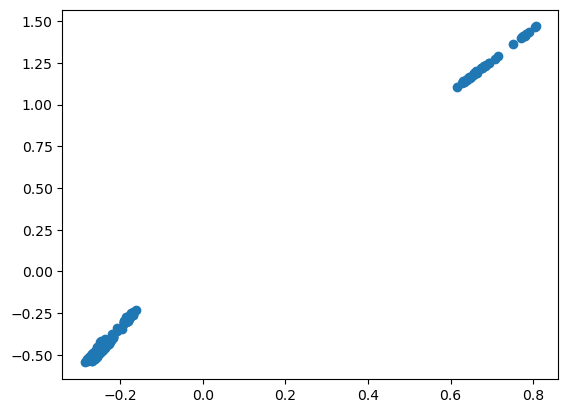

In [143]:
plt.scatter(model.round_zero.h.detach().numpy(), params["bias_Ns0"])

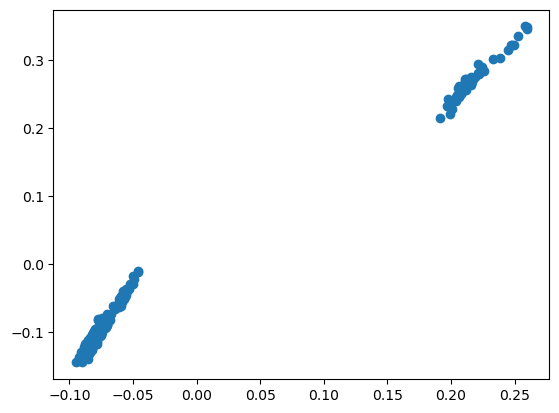

In [144]:
plt.scatter(model.selection.modes[0].h.detach().numpy(), params["bias_ps"])

In [120]:
x = chains[0][:10]

In [121]:
indep_sites.compute_energy(x, {"bias": params["bias_ps"]})

tensor([-0.0848, -0.0719, -0.0175, -0.1240, -0.0124, -0.1303, -0.0368, -0.0521,
        -0.0275, -0.1469])

In [122]:
model.selection_energy_at_round(x, 1)

tensor([-0.6504, -0.5522, -0.1259, -0.9595, -0.0846, -1.0053, -0.2748, -0.3965,
        -0.2071, -1.1358], grad_fn=<SumBackward1>)

In [127]:
params["bias_ps"]

tensor([[ 0.0160, -0.0060, -0.0053, -0.0047],
        [-0.0061, -0.0060, -0.0058,  0.0179],
        [-0.0059, -0.0061,  0.0173, -0.0053],
        [-0.0055, -0.0064,  0.0168, -0.0050],
        [ 0.0158, -0.0062, -0.0056, -0.0040],
        [ 0.0153, -0.0057, -0.0057, -0.0039],
        [-0.0052,  0.0147, -0.0052, -0.0043],
        [-0.0052,  0.0152, -0.0060, -0.0039],
        [-0.0055,  0.0153, -0.0055, -0.0043],
        [-0.0052,  0.0150, -0.0054, -0.0044],
        [-0.0050, -0.0059,  0.0150, -0.0041],
        [ 0.0151, -0.0060, -0.0054, -0.0037],
        [-0.0053,  0.0144, -0.0052, -0.0039],
        [ 0.0161, -0.0058, -0.0059, -0.0044],
        [-0.0062, -0.0062, -0.0061,  0.0186],
        [-0.0055,  0.0148, -0.0051, -0.0043],
        [-0.0057, -0.0061, -0.0068,  0.0185],
        [ 0.0161, -0.0057, -0.0059, -0.0045],
        [-0.0056,  0.0160, -0.0059, -0.0046],
        [-0.0048, -0.0061,  0.0155, -0.0046],
        [-0.0061, -0.0061, -0.0061,  0.0183],
        [-0.0052, -0.0059,  0.0156

In [128]:
h

tensor([[ 0.1246, -0.0471, -0.0415, -0.0370],
        [-0.0479, -0.0470, -0.0450,  0.1388],
        [-0.0470, -0.0479,  0.1350, -0.0412],
        [-0.0431, -0.0504,  0.1312, -0.0388],
        [ 0.1232, -0.0491, -0.0446, -0.0305],
        [ 0.1189, -0.0450, -0.0450, -0.0299],
        [-0.0407,  0.1144, -0.0412, -0.0334],
        [-0.0409,  0.1185, -0.0480, -0.0305],
        [-0.0431,  0.1190, -0.0431, -0.0337],
        [-0.0407,  0.1167, -0.0427, -0.0342],
        [-0.0393, -0.0464,  0.1166, -0.0318],
        [ 0.1174, -0.0475, -0.0422, -0.0286],
        [-0.0417,  0.1119, -0.0410, -0.0299],
        [ 0.1256, -0.0460, -0.0465, -0.0341],
        [-0.0488, -0.0489, -0.0478,  0.1446],
        [-0.0434,  0.1156, -0.0395, -0.0336],
        [-0.0441, -0.0477, -0.0531,  0.1441],
        [ 0.1253, -0.0447, -0.0465, -0.0351],
        [-0.0436,  0.1248, -0.0466, -0.0357],
        [-0.0378, -0.0483,  0.1209, -0.0358],
        [-0.0483, -0.0479, -0.0473,  0.1425],
        [-0.0411, -0.0463,  0.1207